In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing

In [2]:
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import GaussianNB

from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans

from sklearn.metrics import f1_score
import time
from sklearn.metrics import auc, roc_curve, roc_auc_score,confusion_matrix
from itertools import cycle
import matplotlib.pyplot as plt
import matplotlib

import seaborn as sns  # plotting
from scipy import stats


from prettytable import PrettyTable  # To print in tabular format

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


from sklearn.metrics import accuracy_score, confusion_matrix, make_scorer
from sklearn.metrics import auc, f1_score, roc_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_validate, cross_val_predict

%matplotlib inline

In [4]:
dataset1 = pd.read_csv('dataset_RTC.csv')


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9')])

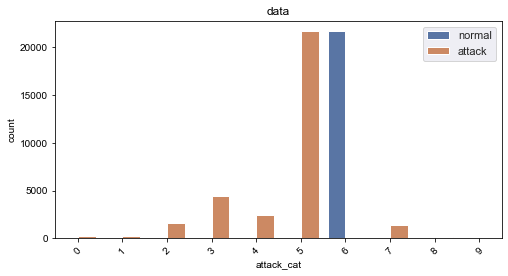

In [5]:
# Ckecj distribution of data
import seaborn as sns
fig, ax = plt.subplots(figsize=(8,4))
sns.set_theme(style="darkgrid")

ax = sns.countplot(x='attack_cat', data=dataset1,hue='label')

ax.legend(loc="upper right", labels=('normal', 'attack'))
ax.set_title("data")
plt.xticks(rotation=45)

In [6]:

dataset1 = dataset1.drop(columns=['Unnamed: 0'])

# Splitting data into train and test

train, test = train_test_split(dataset1, test_size=0.3, random_state=16)

### Models For Label Feature

In [7]:
x_train=[]
y_train=[]
x_test=[]
y_test=[]

x_train= train.iloc[:,:-2].to_numpy()
y_train= train.iloc[:,-1].to_numpy()
x_test = test.iloc[:,:-2].to_numpy()
y_test = test.iloc[:,-1].to_numpy()



# Split The Train and Test data

#x_train, x_test, y_train, y_test = train_test_split( X, y, test_size=0.25, random_state=16)

In [8]:
def false_alarm_rate(y_true, y_pred):
    """
    This function will return False Alarm Rate for given true and predicted values.
    False Alarm Rate is average of False Negetive Rate and False Positive Rate
    """
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    FPR = fp / (fp + tn)  # False positive rate
    FNR = fn / (fn + tp)  # False negetive rate
    return (FPR+FNR)/2  # False alarm rate

In [9]:
def hyperparam_tuning(clf, parameters, x, y, method='gridsearch', cv=None):
    """
    Utility function for Tuning hyperparameters
    """
    # initialization
    scoring = {'auc':'roc_auc',
               'f1':'f1',
               'FAR':make_scorer(false_alarm_rate, greater_is_better=False)}  # using custom scoring function FAR.
                
    # param tuning
    if method=='gridsearch':
        # As we are using multi scoring, So we need to point refit to scoring function with which we want to evaluate score
        tuning_clf = GridSearchCV(clf, parameters, scoring=scoring, refit='auc',
                                  cv=cv, verbose=3, return_train_score=True)
        result = tuning_clf.fit(x, y)
    
    elif method=='randomsearch':
        tuning_clf = RandomizedSearchCV(clf, parameters, scoring=scoring, refit='auc',
                                        cv=cv, verbose=3, return_train_score=True)
        result = tuning_clf.fit(x, y)

    return result

In [10]:
def result_visualization(tuned_clf, parameters, param1=None, param2=None,param3 = None):
    """
    Utility function to plot the results obtained after hyper parameter tuning 
    """
    # getting train and test scores to plot
    train_score = tuned_clf.cv_results_['mean_train_auc']
    test_score = tuned_clf.cv_results_['mean_test_auc']

    # print results
    print("Best Score: {}".format(tuned_clf.best_score_))
    print("Best Parameters: {}".format(tuned_clf.best_params_))

    # Want to visualize score with 2 params, plot heatmap of the 3 variables
    if param2 is not None:
        # heatmap
        train_cmap=sns.light_palette("green")
        test_cmap=sns.light_palette("blue")
        
        # Figure and axis
        fig = plt.figure(figsize=(20,5))
        train_ax = fig.add_subplot(1,2,1)
        test_ax = fig.add_subplot(1,2,2)
        
        # train heatmap
        sns.heatmap(train_score.reshape(len(parameters[param1]), len(parameters[param2])),
                    cmap=train_cmap, annot=True, fmt='.4f', ax=train_ax,
                    xticklabels=parameters[param2], yticklabels=parameters[param1])
        
        # test heapmap
        sns.heatmap(test_score.reshape(len(parameters[param1]), len(parameters[param2])),
                    cmap=test_cmap, annot=True, fmt='.6f', ax=test_ax,
                    xticklabels=parameters[param2], yticklabels=parameters[param1])
        
        # axis labels and plot title
        train_ax.set_title("Train hyperparam heatmap")
        train_ax.set_xlabel(param2)
        train_ax.set_ylabel(param1)

        test_ax.set_title("Test hyperparam heatmap")
        test_ax.set_xlabel(param2)
        test_ax.set_ylabel(param1)
        plt.show()
    
    
        
    
    # Want to visualize score with one param, simply plot score and param
    else:
        plt.figure(figsize=(10,5))
        plt.plot(np.log10(parameters[param1]), train_score, label="train")
        plt.plot(np.log10(parameters[param1]), test_score, label="test")

        # Plot for train data
        for i, txt in enumerate(train_score):
            plt.annotate((parameters[param1][i], np.round(txt, 3)), (np.log10(parameters[param1])[i], train_score[i]))
        
        # Plot for test data
        for i, txt in enumerate(test_score):
            plt.annotate((parameters[param1][i], np.round(txt, 3)), (np.log10(parameters[param1])[i], test_score[i]))
        
        plt.xlabel(param1)
        plt.ylabel('performance')
        plt.grid()
        plt.legend()
        plt.show()

In [11]:
def evaluate_result(clf, x_train, y_train, x_test, y_test, model_name):
    """ 
    Utility function to get result on test data from best found classifier using hyper parameter tuning.
    Print the accuracy and False Alarm Rate for both train and test.
    Plot confusion matrix of train and test.
    """
    cmap=sns.light_palette("blue")
    labels= ['non-attack', 'attack']
    
    # Training te best model
    clf.fit(x_train, y_train)
    y_train_pred = clf.predict(x_train)  # prediction on train data
    y_test_pred = clf.predict(x_test)  # prediction on test data
    
    # auc curve
    train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
    test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)
    
    # Scores of train dataset
    train_auc = auc(train_fpr, train_tpr)
    train_f1 = f1_score(y_train, y_train_pred)
    train_far = false_alarm_rate(y_train, y_train_pred)
    
    # Scores of test dataset
    test_auc = auc(test_fpr, test_tpr)
    test_f1 = f1_score(y_test, y_test_pred)
    test_far = false_alarm_rate(y_test, y_test_pred)
    
    # Printing the result as a table
    x = PrettyTable()
    x.field_names = ['Dataset', 'Model', 'AUC', 'F1-score', 'False Alarm Rate']
    x.add_row(['Train', model_name, train_auc, train_f1, train_far])
    x.add_row(['Test', model_name, test_auc, test_f1, test_far])
    print(x)

    # Plot AUC curve
    plt.figure()
    plt.plot(train_fpr, train_tpr, label=f"Train AUC: {train_auc}")
    plt.plot(test_fpr, test_tpr, label=f"Test AUC: {test_auc}")
    plt.grid()
    plt.legend()
    plt.show()

    # Confusion martix of train and test
    # Train confusion matrix
    plt.figure(figsize=(16,5))
    plt.subplot(1,2,1)
    sns.heatmap(confusion_matrix(y_train, y_train_pred),
                annot=True, cmap=cmap, fmt='d',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Train Confusion Matrix")

    # Test confusion matrix
    plt.subplot(1,2,2)
    sns.heatmap(confusion_matrix(y_test, y_test_pred),
                annot=True, cmap=cmap, fmt='d',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Test Confusion Matrix")
    plt.show()
    
    # Returning scores of test data
    return clf, test_auc, test_f1, test_far

### Logistic Regression

#### We are starting with basic Logistic Regression for training our data.

#### Going to tune hyperparameter "alpha" and "penalty"

In [12]:
# Tuning "alpha" for l2 "penalty"
clf = SGDClassifier(loss='log', penalty='l2')
param = {'alpha':np.logspace(-6, 1, 8)}  # Values of alpha

lr_clf = hyperparam_tuning(clf, param, x_train, y_train, cv=3)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] alpha=1e-06 .....................................................
[CV]  alpha=1e-06, FAR=(train=-0.008, test=-0.010), auc=(train=0.997, test=0.996), f1=(train=0.994, test=0.993), total=   0.2s
[CV] alpha=1e-06 .....................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV]  alpha=1e-06, FAR=(train=-0.009, test=-0.009), auc=(train=0.996, test=0.997), f1=(train=0.994, test=0.994), total=   0.2s
[CV] alpha=1e-06 .....................................................
[CV]  alpha=1e-06, FAR=(train=-0.009, test=-0.008), auc=(train=0.997, test=0.997), f1=(train=0.994, test=0.995), total=   0.2s
[CV] alpha=1e-05 .....................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s


[CV]  alpha=1e-05, FAR=(train=-0.008, test=-0.010), auc=(train=0.997, test=0.996), f1=(train=0.994, test=0.993), total=   0.1s
[CV] alpha=1e-05 .....................................................
[CV]  alpha=1e-05, FAR=(train=-0.009, test=-0.009), auc=(train=0.997, test=0.997), f1=(train=0.994, test=0.994), total=   0.1s
[CV] alpha=1e-05 .....................................................
[CV]  alpha=1e-05, FAR=(train=-0.010, test=-0.009), auc=(train=0.998, test=0.997), f1=(train=0.993, test=0.994), total=   0.1s
[CV] alpha=0.0001 ....................................................
[CV]  alpha=0.0001, FAR=(train=-0.009, test=-0.010), auc=(train=0.993, test=0.992), f1=(train=0.994, test=0.993), total=   0.0s
[CV] alpha=0.0001 ....................................................
[CV]  alpha=0.0001, FAR=(train=-0.010, test=-0.009), auc=(train=0.995, test=0.995), f1=(train=0.993, test=0.993), total=   0.1s
[CV] alpha=0.0001 ....................................................
[CV]  al

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    2.0s finished


Best Score: 0.9970368551500487
Best Parameters: {'alpha': 1e-05}


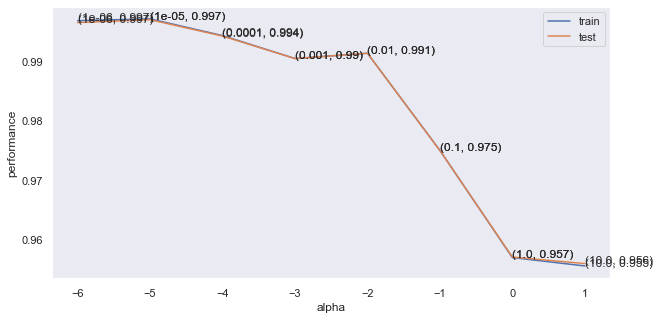

In [13]:
# Plotting the result to select best parameter
result_visualization(lr_clf, param, param1= 'alpha')

In [14]:
# Tuning "alpha" for l1 "penalty"
clf = SGDClassifier(loss='log', penalty='l1')
param = {'alpha':np.logspace(-6, 1, 8)}  # Values of alpha

lr_clf = hyperparam_tuning(clf, param, x_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] alpha=1e-06 .....................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  alpha=1e-06, FAR=(train=-0.008, test=-0.010), auc=(train=0.995, test=0.995), f1=(train=0.994, test=0.993), total=   0.3s
[CV] alpha=1e-06 .....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV]  alpha=1e-06, FAR=(train=-0.009, test=-0.009), auc=(train=0.995, test=0.995), f1=(train=0.994, test=0.994), total=   0.3s
[CV] alpha=1e-06 .....................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s


[CV]  alpha=1e-06, FAR=(train=-0.010, test=-0.009), auc=(train=0.995, test=0.994), f1=(train=0.993, test=0.994), total=   0.3s
[CV] alpha=1e-06 .....................................................
[CV]  alpha=1e-06, FAR=(train=-0.009, test=-0.011), auc=(train=0.995, test=0.995), f1=(train=0.994, test=0.993), total=   0.2s
[CV] alpha=1e-06 .....................................................
[CV]  alpha=1e-06, FAR=(train=-0.009, test=-0.006), auc=(train=0.995, test=0.995), f1=(train=0.994, test=0.996), total=   0.3s
[CV] alpha=1e-05 .....................................................
[CV]  alpha=1e-05, FAR=(train=-0.009, test=-0.010), auc=(train=0.996, test=0.996), f1=(train=0.994, test=0.993), total=   0.1s
[CV] alpha=1e-05 .....................................................
[CV]  alpha=1e-05, FAR=(train=-0.008, test=-0.009), auc=(train=0.996, test=0.995), f1=(train=0.994, test=0.994), total=   0.1s
[CV] alpha=1e-05 .....................................................
[CV]  alph

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    4.7s finished


Best Score: 0.9966690976640538
Best Parameters: {'alpha': 0.0001}


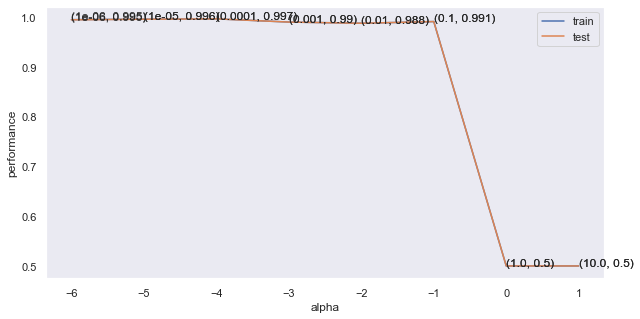

In [15]:
# Plotting alpha vs score
result_visualization(lr_clf, param, 'alpha')

In [16]:
# Best LR model
lr_bst_clf = SGDClassifier(penalty='l1', alpha=1e-6)

+---------+-------+--------------------+--------------------+----------------------+
| Dataset | Model |        AUC         |      F1-score      |   False Alarm Rate   |
+---------+-------+--------------------+--------------------+----------------------+
|  Train  |   LR  | 0.9912234215352218 | 0.9938054652490994 | 0.00877657846477828  |
|   Test  |   LR  | 0.9907514887348863 | 0.9931460262648459 | 0.009248511265113701 |
+---------+-------+--------------------+--------------------+----------------------+


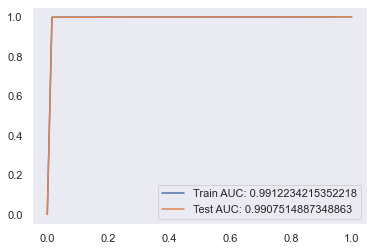

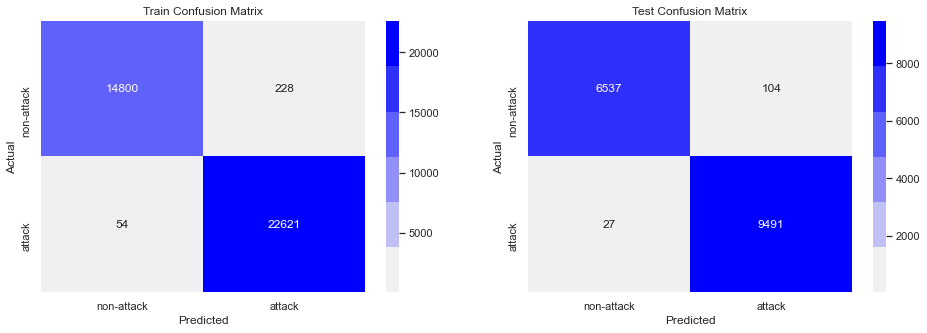

In [17]:
# Getting best model's performance on train and test data
lr_clf, lr_auc, lr_f1, lr_far = evaluate_result(lr_bst_clf, x_train, y_train, x_test, y_test, 'LR')

#### Observation

- Using wide range of values for "alpha" from 10^-6 to 10^3 and "penalty" l1 and l2
- Can observe that upto alpha=0.1 model's score is good and then its falling down heavily.
- The best parameter of the model for our data is "penalty" l1 and "alpha" 10^-6
- Both train and test auc score are very close that means model is not overfitting.
- Model is performing well but there are few False Positive points in the result

In [18]:
# An empty dictionary to store the result of all the models
result_dict = {"name":[], "auc":[], "f1":[], "far":[]}

In [19]:
# Storinig result for LR
result_dict['name'].append("LR")
result_dict['auc'].append(lr_auc)
result_dict['f1'].append(lr_f1)
result_dict['far'].append(lr_far)

In [20]:
result_dict

{'name': ['LR'],
 'auc': [0.9907514887348863],
 'f1': [0.9931460262648459],
 'far': [0.009248511265113701]}

### Linear SVC

#### The next model we are going to try is Linear Support Vector Classifier

#### Tune parameters for "alpha" and "penalty"

In [21]:
# Tuning "alpha" and "penalty"
clf = SGDClassifier(loss='hinge')
param = {'alpha':[10**x for x in range(-5,3)],  # Values for alpha
         'penalty':['l1', 'l2']}  # l1 an d l2 penalty

svm_clf = hyperparam_tuning(clf, param, x_train, y_train, cv=3)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] alpha=1e-05, penalty=l1 .........................................
[CV]  alpha=1e-05, penalty=l1, FAR=(train=-0.008, test=-0.010), auc=(train=0.994, test=0.993), f1=(train=0.994, test=0.993), total=   0.1s
[CV] alpha=1e-05, penalty=l1 .........................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV]  alpha=1e-05, penalty=l1, FAR=(train=-0.011, test=-0.012), auc=(train=0.993, test=0.993), f1=(train=0.991, test=0.990), total=   0.1s
[CV] alpha=1e-05, penalty=l1 .........................................
[CV]  alpha=1e-05, penalty=l1, FAR=(train=-0.010, test=-0.008), auc=(train=0.995, test=0.995), f1=(train=0.993, test=0.994), total=   0.1s
[CV] alpha=1e-05, penalty=l2 .........................................
[CV]  alpha=1e-05, penalty=l2, FAR=(train=-0.008, test=-0.009), auc=(train=0.997, test=0.997), f1=(train=0.995, test=0.994), total=   0.0s
[CV] alpha=1e-05, penalty=l2 .........................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


[CV]  alpha=1e-05, penalty=l2, FAR=(train=-0.008, test=-0.008), auc=(train=0.995, test=0.995), f1=(train=0.994, test=0.994), total=   0.0s
[CV] alpha=1e-05, penalty=l2 .........................................
[CV]  alpha=1e-05, penalty=l2, FAR=(train=-0.009, test=-0.008), auc=(train=0.993, test=0.992), f1=(train=0.994, test=0.995), total=   0.0s
[CV] alpha=0.0001, penalty=l1 ........................................
[CV]  alpha=0.0001, penalty=l1, FAR=(train=-0.008, test=-0.009), auc=(train=0.992, test=0.991), f1=(train=0.995, test=0.994), total=   0.0s
[CV] alpha=0.0001, penalty=l1 ........................................
[CV]  alpha=0.0001, penalty=l1, FAR=(train=-0.009, test=-0.009), auc=(train=0.996, test=0.996), f1=(train=0.994, test=0.994), total=   0.0s
[CV] alpha=0.0001, penalty=l1 ........................................
[CV]  alpha=0.0001, penalty=l1, FAR=(train=-0.009, test=-0.008), auc=(train=0.992, test=0.991), f1=(train=0.994, test=0.994), total=   0.0s
[CV] alpha=0.0001,

[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:    3.1s finished


Best Score: 0.9946985708091729
Best Parameters: {'alpha': 1e-05, 'penalty': 'l2'}


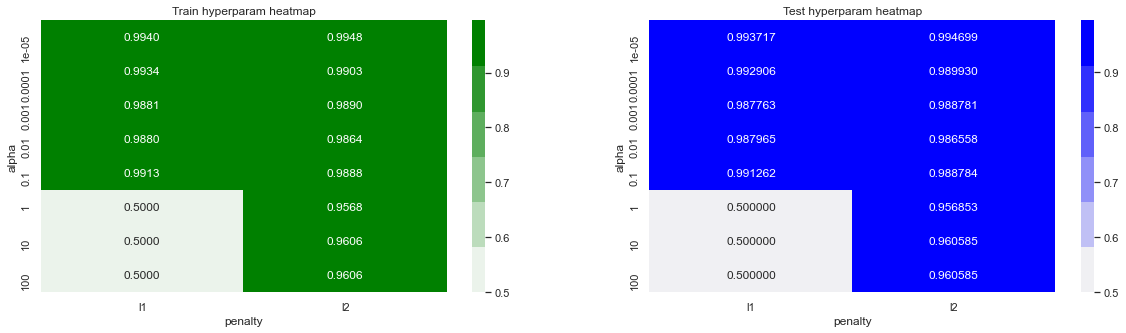

In [22]:
# Visualising scores, using heatmap to check the performance on "alpha" and "penalty"
result_visualization(svm_clf, param, 'alpha', 'penalty')

In [23]:
# Best svc model
best_svm_clf = svm_clf.best_estimator_

+---------+-------+--------------------+--------------------+----------------------+
| Dataset | Model |        AUC         |      F1-score      |   False Alarm Rate   |
+---------+-------+--------------------+--------------------+----------------------+
|  Train  |  SVM  | 0.9909870102086542 | 0.9938564156573634 | 0.009012989791345754 |
|   Test  |  SVM  | 0.9908233613680372 | 0.9935234513736549 | 0.009176638631962726 |
+---------+-------+--------------------+--------------------+----------------------+


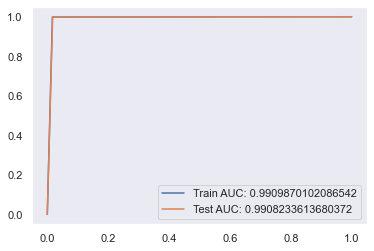

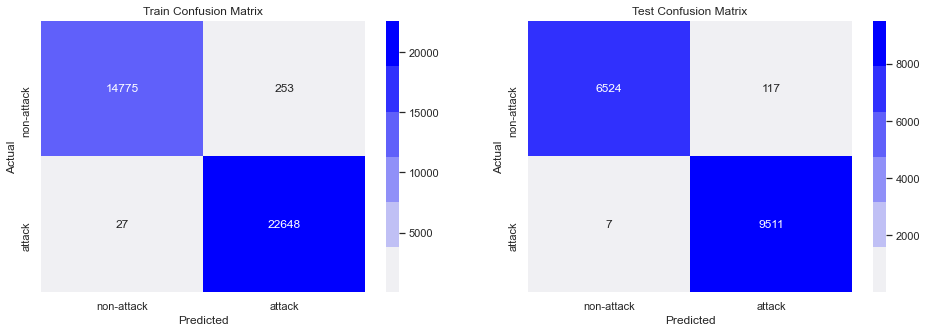

In [24]:
# Model performance on train and test
svm_clf, svm_auc, svm_f1, svm_far = evaluate_result(clf, x_train, y_train, x_test, y_test, "SVM")


### Observation

- Using wide range of "alpha" values from 10^-5 to 10^2 and l1, l2 "penalty"
- For penalty=l1 model is behaving like a random model with auc=0.5 from alpha=1 to 100.
- Best set of parameters for the model is alpha=10^-4 and penalty=l2
- Train and Test score is very close so no overfitting here, getting better value of auc and FAR tha Logistic Regression
- FAR value of this model is really good. The no of FP increased than LR but there are very few FN points in the result.


In [25]:
# Saving result of SVM
result_dict['name'].append("SVM")
result_dict['auc'].append(svm_auc)
result_dict['f1'].append(svm_f1)
result_dict['far'].append(svm_far)

### KNN
#### Tuning parameters like n_neighnors', 'weights','metric'

In [26]:
# Tuning n_neighnors', 'weights','metric'
clf = KNeighborsClassifier()
param = {'n_neighbors':[3,5,11], 
         'weights':['uniform', 'distance'], 
          'metric': ['euclidean', 'manhattan']}  

knn_clf = hyperparam_tuning(clf, param, x_train, y_train, cv=3)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] metric=euclidean, n_neighbors=3, weights=uniform ................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  metric=euclidean, n_neighbors=3, weights=uniform, FAR=(train=-0.006, test=-0.008), auc=(train=1.000, test=0.995), f1=(train=0.996, test=0.995), total=   1.9s
[CV] metric=euclidean, n_neighbors=3, weights=uniform ................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.4s remaining:    0.0s


[CV]  metric=euclidean, n_neighbors=3, weights=uniform, FAR=(train=-0.006, test=-0.008), auc=(train=1.000, test=0.994), f1=(train=0.996, test=0.994), total=   2.1s
[CV] metric=euclidean, n_neighbors=3, weights=uniform ................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   11.2s remaining:    0.0s


[CV]  metric=euclidean, n_neighbors=3, weights=uniform, FAR=(train=-0.007, test=-0.008), auc=(train=1.000, test=0.995), f1=(train=0.995, test=0.994), total=   2.3s
[CV] metric=euclidean, n_neighbors=3, weights=distance ...............
[CV]  metric=euclidean, n_neighbors=3, weights=distance, FAR=(train=-0.000, test=-0.008), auc=(train=1.000, test=0.995), f1=(train=1.000, test=0.994), total=   1.7s
[CV] metric=euclidean, n_neighbors=3, weights=distance ...............
[CV]  metric=euclidean, n_neighbors=3, weights=distance, FAR=(train=-0.000, test=-0.008), auc=(train=1.000, test=0.994), f1=(train=1.000, test=0.994), total=   1.9s
[CV] metric=euclidean, n_neighbors=3, weights=distance ...............
[CV]  metric=euclidean, n_neighbors=3, weights=distance, FAR=(train=-0.000, test=-0.008), auc=(train=1.000, test=0.995), f1=(train=1.000, test=0.994), total=   2.1s
[CV] metric=euclidean, n_neighbors=5, weights=uniform ................
[CV]  metric=euclidean, n_neighbors=5, weights=uniform, F

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  3.9min finished


Best Score: 0.9973972882949109
Best Parameters: {'metric': 'euclidean', 'n_neighbors': 11, 'weights': 'distance'}


ValueError: cannot reshape array of size 12 into shape (3,2)

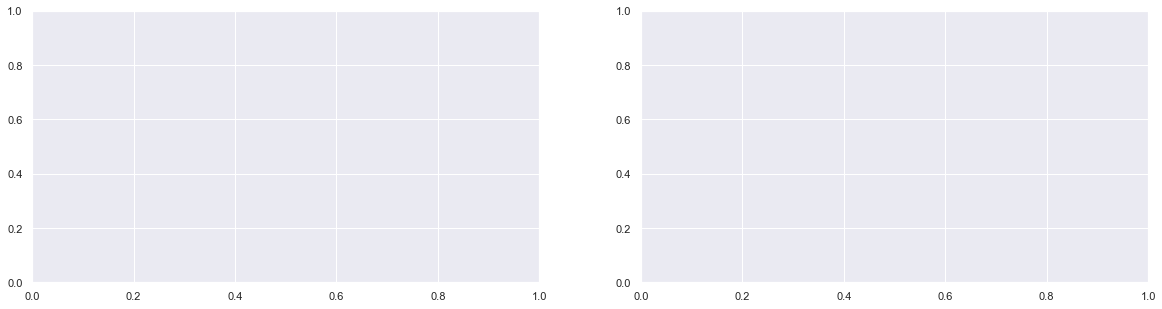

In [27]:
# Visualising scores, using heatmap to check the performance on neighbors,metric, and weights
result_visualization(knn_clf, param, 'n_neighbors', 'weights','metric')

In [28]:
# Best knn model
best_knn_clf = knn_clf.best_estimator_

+---------+-------+--------------------+--------------------+-----------------------+
| Dataset | Model |        AUC         |      F1-score      |    False Alarm Rate   |
+---------+-------+--------------------+--------------------+-----------------------+
|  Train  |  KNN  | 0.9931256377290872 | 0.9953662018227737 | 0.0068743622709127455 |
|   Test  |  KNN  | 0.9922993844646079 | 0.9945092297233697 | 0.0077006155353922644 |
+---------+-------+--------------------+--------------------+-----------------------+


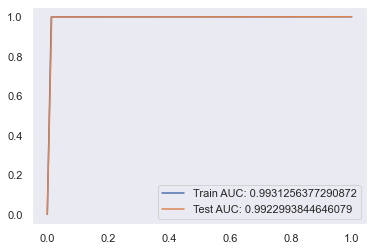

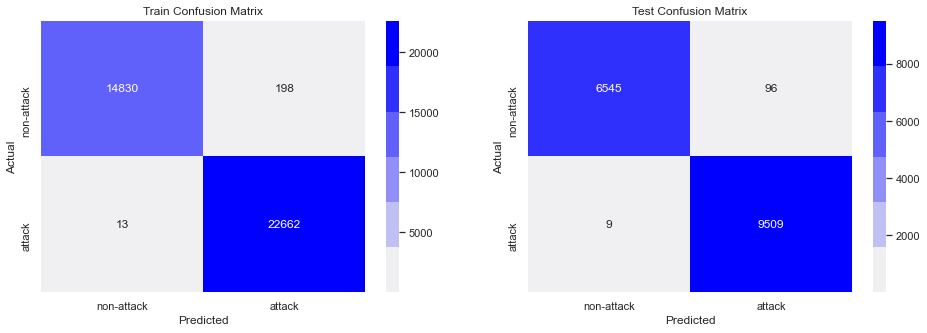

In [29]:
# Model performance on train and test
knn_clf, knn_auc, knn_f1, knn_far = evaluate_result(clf, x_train, y_train, x_test, y_test, "KNN")


#### Observation

- Using k  values (3,5,11), metric as euclidean and Manhatatn, and weights parameters
- For k = 11, metric = 'manhattan', and  weights = 'distance' model is behaving good with auc=0.99 
- Best set of parameters for the model are k = 11, metric = 'manhattan', and  weights = 'distance'
- Train and Test score is very close so no overfitting here, getting better value of auc.
- FAR value of this model is really good. There are very few FN points in the result.
  

In [30]:
# Saving result of KNN
result_dict['name'].append("KNN")
result_dict['auc'].append(knn_auc)
result_dict['f1'].append(knn_f1)
result_dict['far'].append(knn_far)

### Naive Bayes Model

In [31]:

clf = GaussianNB()
param = {'var_smoothing': np.logspace(0,-9, num=100)} 

nb_clf = hyperparam_tuning(clf, param, x_train, y_train, cv=3)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] var_smoothing=1.0 ...............................................
[CV]  var_smoothing=1.0, FAR=(train=-0.114, test=-0.110), auc=(train=0.961, test=0.962), f1=(train=0.903, test=0.906), total=   0.0s
[CV] var_smoothing=1.0 ...............................................
[CV]  var_smoothing=1.0, FAR=(train=-0.113, test=-0.112), auc=(train=0.961, test=0.962), f1=(train=0.904, test=0.905), total=   0.0s
[CV] var_smoothing=1.0 ...............................................
[CV]  var_smoothing=1.0, FAR=(train=-0.111, test=-0.117), auc=(train=0.962, test=0.960), f1=(train=0.906, test=0.901), total=   0.0s
[CV] var_smoothing=0.8111308307896871 ................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


[CV]  var_smoothing=0.8111308307896871, FAR=(train=-0.112, test=-0.107), auc=(train=0.963, test=0.963), f1=(train=0.906, test=0.910), total=   0.0s
[CV] var_smoothing=0.8111308307896871 ................................
[CV]  var_smoothing=0.8111308307896871, FAR=(train=-0.110, test=-0.109), auc=(train=0.963, test=0.964), f1=(train=0.907, test=0.909), total=   0.0s
[CV] var_smoothing=0.8111308307896871 ................................
[CV]  var_smoothing=0.8111308307896871, FAR=(train=-0.108, test=-0.114), auc=(train=0.964, test=0.962), f1=(train=0.909, test=0.904), total=   0.0s
[CV] var_smoothing=0.657933224657568 .................................
[CV]  var_smoothing=0.657933224657568, FAR=(train=-0.107, test=-0.102), auc=(train=0.964, test=0.965), f1=(train=0.911, test=0.915), total=   0.0s
[CV] var_smoothing=0.657933224657568 .................................
[CV]  var_smoothing=0.657933224657568, FAR=(train=-0.105, test=-0.105), auc=(train=0.964, test=0.965), f1=(train=0.912, test=

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   15.6s finished


Best Score: 0.9875626265604058
Best Parameters: {'var_smoothing': 0.04328761281083057}


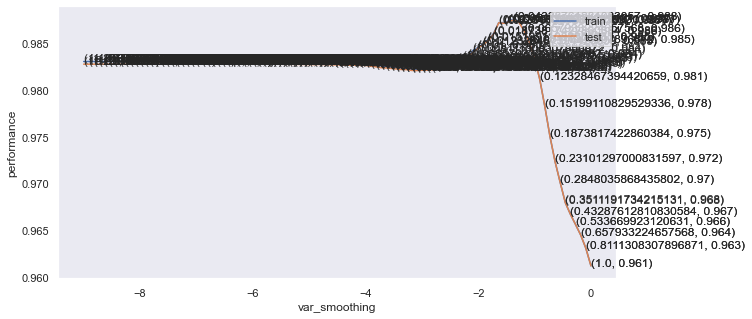

In [33]:
# Visualising scores, using heatmap to check the performance parameters
result_visualization(nb_clf, param, 'var_smoothing')

In [34]:
# Best Naive Bayes model
best_knn_clf = nb_clf.best_estimator_

+---------+-------+--------------------+--------------------+----------------------+
| Dataset | Model |        AUC         |      F1-score      |   False Alarm Rate   |
+---------+-------+--------------------+--------------------+----------------------+
|  Train  |   NB  | 0.9394175855198924 | 0.9596412556053813 | 0.060582414480107545 |
|   Test  |   NB  | 0.9389446806641797 | 0.9569465648854963 |  0.0610553193358203  |
+---------+-------+--------------------+--------------------+----------------------+


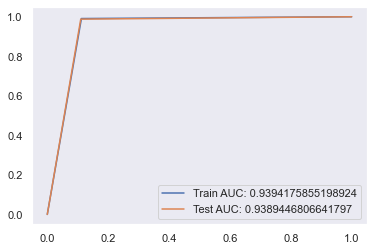

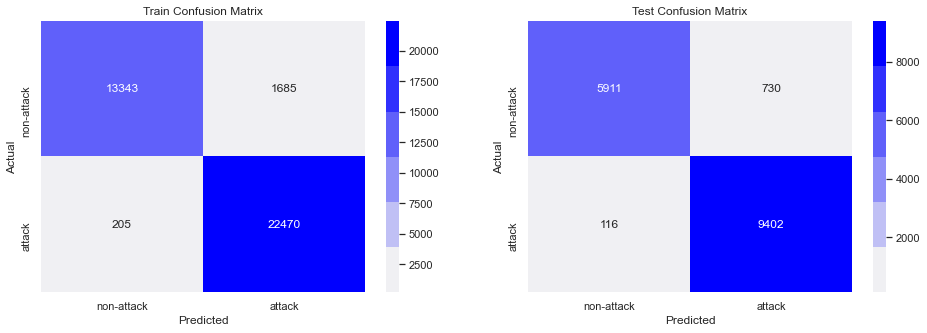

In [35]:
# Model performance on train and test
nb_clf,nb_auc, nb_f1,nb_far = evaluate_result(clf, x_train, y_train, x_test, y_test, "NB")


In [36]:
# Saving result of NB
result_dict['name'].append("NB")
result_dict['auc'].append(nb_auc)
result_dict['f1'].append(nb_f1)
result_dict['far'].append(nb_far)

In [37]:
pd.DataFrame(result_dict)

,name,auc,f1,far
0,LR,0.990751,0.993146,0.009249
1,SVM,0.990823,0.993523,0.009177
2,KNN,0.992299,0.994509,0.007701
3,NB,0.938945,0.956947,0.061055


### Ensembles
#### Voting Classifier Model
Trining a ensemble model using voting classifier, Taking 2 classifiers LogisticRegression, SVM



In [38]:
from sklearn.ensemble import VotingClassifier
from sklearn.calibration import CalibratedClassifierCV
# Initializing all the 3 classifiers with best found parameters


knn_clf = KNeighborsClassifier( metric = 'manhattan', n_neighbors=11, weights= 'distance')

nb_clf = GaussianNB(priors=None, var_smoothing=0.02848035868435802)

#log_clf = SGDClassifier( alpha= 1e-6,penalty = 'l1')

+---------+------------+--------------------+--------------------+-----------------------+
| Dataset |   Model    |        AUC         |      F1-score      |    False Alarm Rate   |
+---------+------------+--------------------+--------------------+-----------------------+
|  Train  | Voting Clf | 0.9999779492833517 | 0.9999779487971069 | 2.205071664829107e-05 |
|   Test  | Voting Clf | 0.9901929768334712 | 0.9928922337200794 |  0.009807023166528811 |
+---------+------------+--------------------+--------------------+-----------------------+


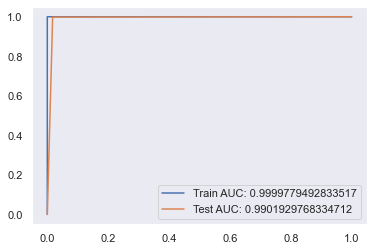

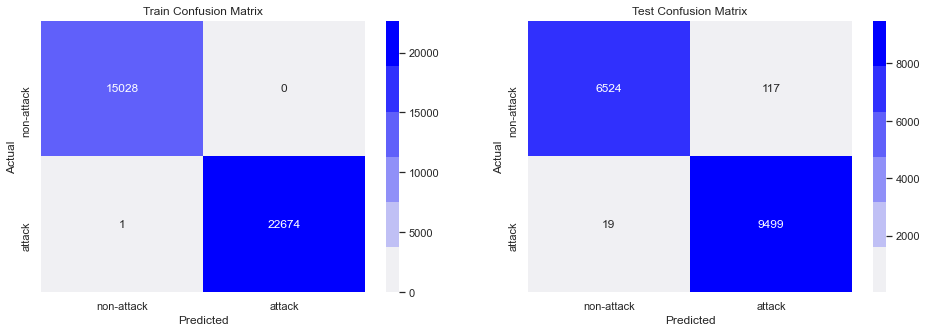

In [39]:
# Result with voting classifier
v_clf = VotingClassifier(estimators=[('knn', knn_clf),('nb', nb_clf)], voting='soft', n_jobs=-1)
v_clf, v_auc, v_f1, v_far = evaluate_result(v_clf, x_train, y_train, x_test, y_test, "Voting Clf")
print()

In [40]:
for i,j in zip(result_dict.keys(), ["Voting", v_auc, v_f1, v_far]):
    result_dict[i].append(j)

pd.DataFrame(result_dict)


,name,auc,f1,far
0,LR,0.990751,0.993146,0.009249
1,SVM,0.990823,0.993523,0.009177
2,KNN,0.992299,0.994509,0.007701
3,NB,0.938945,0.956947,0.061055
4,Voting,0.990193,0.992892,0.009807


### Observations

- Training this model using 2 model best KNN and best NB.
- The auc score of this model is higher than models SVM and Logistic Regression.
- There is a gap in train and test auc and higher gap in train and test f1 and FAR
- In train the FAR is very very low but in test there are still few FP and FN and they are almost equal in number


In [41]:
best_model = KNeighborsClassifier( metric = 'manhattan', n_neighbors=11, weights= 'distance')
best_model.fit(x_train, y_train)

KNeighborsClassifier(metric='manhattan', n_neighbors=11, weights='distance')

In [42]:
best_model_score = f1_score(y_test, best_model.predict(x_test))
print("The best model (KNN) F1 score is = ", best_model_score )

The best model (KNN) F1 score is =  0.9947715152148907


## Models For Multiclass Classification ('attack_cat') and using the best hyperparameters from Binary Classification(label)

In [43]:
X=[]
y=[]
X = dataset1.iloc[:,:-2].to_numpy()
y = dataset1.iloc[:,-2].to_numpy()

In [46]:
def plot_roc(y_pred_val, y_testlb_val, y_predlb_val, classifier,count):
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(len(np.unique(y_pred_val))):
    fpr[i], tpr[i], _ = roc_curve(y_testlb_val[:, i], y_predlb_val[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
  n_classes = len(np.unique(y_pred_val))
  print('n_classes',n_classes)
  print('fpr[i] ',fpr[i])
  print('tpr[i] ',tpr[i])
  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    # Plot all ROC curves
  plt.figure()
  colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
  for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
               label='ROC curve of class {0} (area = {1:0.2f})'''.format(i, roc_auc[i]))
  plt.plot([0, 1], [0, 1], 'k--', lw=2)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristics '+ classifier)
  plt.legend(loc="lower right")
  plt.savefig('ROC '+classifier+' '+str(count)+'.png')
  plt.show()
  plt.clf()

In [71]:
#F1 score - F1 Score is the weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account.  
#F1 is usually more useful than accuracy, especially if you have an uneven class distribution.
    
import matplotlib
def plot_F1score_metrics(title_,list_,l1,l2,l3,l4,l5):
    matplotlib.rc('figure', figsize=(10, 5))

    plt.title(title_)
    plt.plot(list_[0],'y',list_[1], 'r',list_[2],'g' ,list_[3],'b',list_[4],'c',markersize=15)
    [a,b,c,d,e] = plt.plot(list_[0],'yo',list_[1], 'ro',list_[2],'go',list_[3],'bo',list_[4],'co',markersize=10)
    plt.legend([a,b,c,d,e], [l1,l2,l3,l4,l5], loc=8,prop={'size': 12})
    plt.show()

TRAIN: [    0     1     2 ... 53859 53860 53861] TEST: [    3     5    10 ... 53842 53848 53852]
n_classes 9
fpr[i]  [0.00000000e+00 8.37910809e-04 1.00000000e+00]
tpr[i]  [0.      0.21875 1.     ]


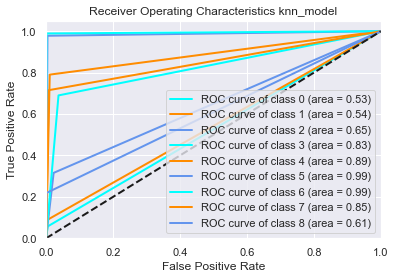

Time taken by Nearest Neighbor model:  1.55095799999998 seconds 

F1 score at each iteration:  0.9129304743339831 

ROC_AUC score for iteration:  0.7639219093016165 

TRAIN: [    0     1     2 ... 53858 53860 53861] TEST: [    7     8    16 ... 53851 53857 53859]
n_classes 9
fpr[i]  [0.00000000e+00 8.37910809e-04 1.00000000e+00]
tpr[i]  [0.      0.34375 1.     ]


<Figure size 432x288 with 0 Axes>

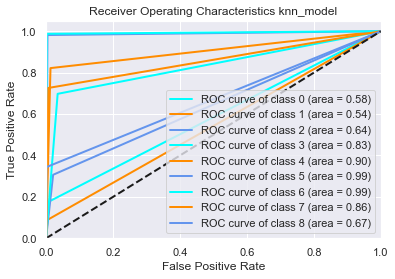

Time taken by Nearest Neighbor model:  1.555453 seconds 

F1 score at each iteration:  0.9166434605031096 

ROC_AUC score for iteration:  0.7798311285622711 

TRAIN: [    0     1     2 ... 53859 53860 53861] TEST: [   12    15    23 ... 53838 53841 53856]
n_classes 10
fpr[i]  [0.00000000e+00 9.28505107e-05 1.00000000e+00]
tpr[i]  [0. 0. 1.]


<Figure size 432x288 with 0 Axes>

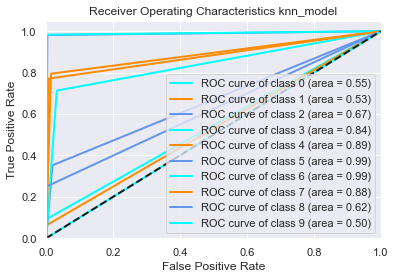

Time taken by Nearest Neighbor model:  1.5276769999999829 seconds 

F1 score at each iteration:  0.9168213887857408 

ROC_AUC score for iteration:  0.7459637934984094 

TRAIN: [    0     2     3 ... 53858 53859 53860] TEST: [    1     4     9 ... 53844 53854 53861]
n_classes 10
fpr[i]  [0. 0. 1.]
tpr[i]  [0.         0.33333333 1.        ]


<Figure size 432x288 with 0 Axes>

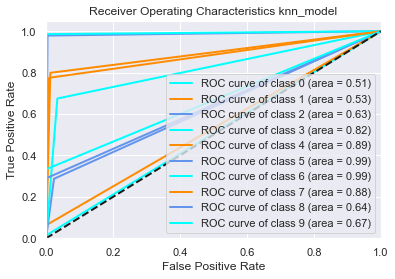

Time taken by Nearest Neighbor model:  1.6263979999999947 seconds 

F1 score at each iteration:  0.9118083921277387 

ROC_AUC score for iteration:  0.7557883425184607 

TRAIN: [    1     3     4 ... 53857 53859 53861] TEST: [    0     2     6 ... 53855 53858 53860]
n_classes 10
fpr[i]  [0. 0. 1.]
tpr[i]  [0.         0.33333333 1.        ]


<Figure size 432x288 with 0 Axes>

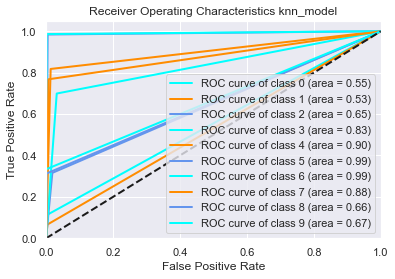

Time taken by Nearest Neighbor model:  1.7428989999999658 seconds 

F1 score at each iteration:  0.9180282213145191 

ROC_AUC score for iteration:  0.7655129843908853 

F1 score for Nearest Neighbor model prediction:  [0.9129304743339831, 0.9166434605031096, 0.9168213887857408, 0.9118083921277387, 0.9180282213145191] 

ROC_AUC score for Nearest Neighbor model prediction: 


<Figure size 432x288 with 0 Axes>

In [48]:
# Training Model with Nearest Neighbors Classifier :
skf = StratifiedKFold(n_splits=5,shuffle = True)
nn_score = []
nn_time = []
roc_score_knn = []


for train_index, test_index in skf.split(X, y):
     count = 0
     print("TRAIN:", train_index, "TEST:", test_index)

     X_train, X_test = X[train_index], X[test_index]
     y_train, y_test = y[train_index], y[test_index]
     s = time.process_time()

     knn_model = KNeighborsClassifier(metric='manhattan', n_neighbors=11, weights='distance')
     knn_model.fit(X_train,y_train)
     y_pred = knn_model.predict(X_test)
     e = time.process_time() - s
     nn_time.append(e) 

     lb = preprocessing.LabelBinarizer()
     y_testlb = lb.fit_transform(y_test)
     y_predlb = lb.fit_transform(y_pred)

     score = f1_score(y_test,y_pred, average='micro')
     nn_score.append(score)
     score1 = roc_auc_score(y_testlb,y_predlb)
     roc_score_knn .append(score1)
     plot_roc(y_pred, y_testlb, y_predlb, 'knn_model',count)
     count+=1

     print("Time taken by Nearest Neighbor model: ", e,"seconds \n")
     print("F1 score at each iteration: ",score,'\n')
     print("ROC_AUC score for iteration: ",score1,'\n')

print("F1 score for Nearest Neighbor model prediction: ",nn_score ,'\n')
print("ROC_AUC score for Nearest Neighbor model prediction: ")

In [49]:
for train_index, test_index in skf.split(X, y):
     count = 0
     print("TRAIN:", train_index, "TEST:", test_index)

TRAIN: [    0     1     2 ... 53859 53860 53861] TEST: [   16    19    21 ... 53852 53855 53856]
TRAIN: [    2     3     6 ... 53858 53859 53861] TEST: [    0     1     4 ... 53854 53857 53860]
TRAIN: [    0     1     4 ... 53859 53860 53861] TEST: [    2     3    11 ... 53839 53844 53853]
TRAIN: [    0     1     2 ... 53859 53860 53861] TEST: [    6     7     8 ... 53837 53841 53851]
TRAIN: [    0     1     2 ... 53856 53857 53860] TEST: [   14    15    20 ... 53858 53859 53861]


In [50]:
count

0

In [51]:
y_test

array([5, 5, 5, ..., 3, 4, 4])

In [52]:
y_pred

array([5, 5, 5, ..., 3, 7, 4])

## Model 2 

TRAIN: [    1     2     3 ... 53858 53859 53860] TEST: [    0     4     8 ... 53846 53855 53861]
n_classes 9
fpr[i]  [0.00000000e+00 1.86202402e-04 1.00000000e+00]
tpr[i]  [0. 0. 1.]


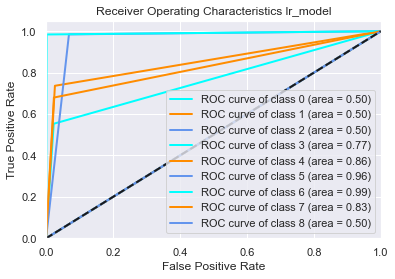

Time taken by Logistic Regression model:  2.5717200000000275 seconds 

F1 score at each iteration:  0.8882391163092918 

ROC_AUC score for iteration:  0.7108224832436529 

TRAIN: [    0     2     3 ... 53858 53859 53861] TEST: [    1    17    32 ... 53852 53853 53860]
n_classes 7
fpr[i]  [0.         0.04519335 1.        ]
tpr[i]  [0.         0.00115367 1.        ]


<Figure size 432x288 with 0 Axes>

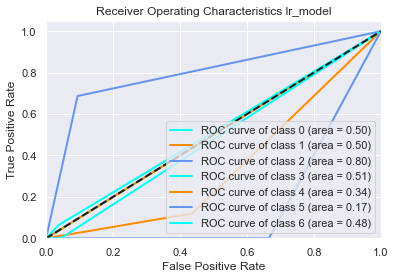

Time taken by Logistic Regression model:  2.803820999999971 seconds 

F1 score at each iteration:  0.8913951545530493 

ROC_AUC score for iteration:  0.4708698619176736 

TRAIN: [    0     1     2 ... 53859 53860 53861] TEST: [    3     5     6 ... 53849 53850 53851]
n_classes 7
fpr[i]  [0.         0.09474992 1.        ]
tpr[i]  [0.         0.00323027 1.        ]


<Figure size 432x288 with 0 Axes>

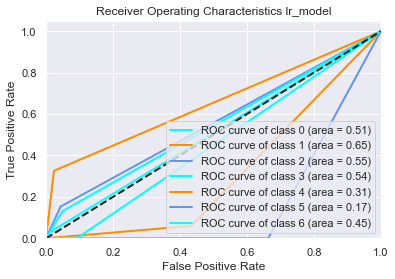

Time taken by Logistic Regression model:  2.780407000000025 seconds 

F1 score at each iteration:  0.8884144077237282 

ROC_AUC score for iteration:  0.45603813105549845 

TRAIN: [    0     1     2 ... 53856 53860 53861] TEST: [    7    11    15 ... 53857 53858 53859]
n_classes 9
fpr[i]  [0.00000000e+00 2.79303603e-04 1.00000000e+00]
tpr[i]  [0. 0. 1.]


<Figure size 432x288 with 0 Axes>

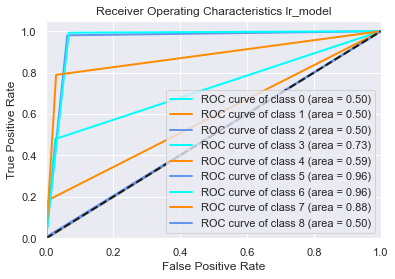

Time taken by Logistic Regression model:  2.7026769999999942 seconds 

F1 score at each iteration:  0.8618640920906053 

ROC_AUC score for iteration:  0.6797456142999418 

TRAIN: [    0     1     3 ... 53859 53860 53861] TEST: [    2     9    14 ... 53840 53847 53856]
n_classes 9
fpr[i]  [0.00000000e+00 9.31098696e-05 1.00000000e+00]
tpr[i]  [0. 0. 1.]


<Figure size 432x288 with 0 Axes>

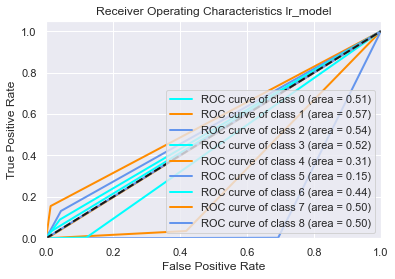

Time taken by Logistic Regression model:  2.7410079999999653 seconds 

F1 score at each iteration:  0.879780913479391 

ROC_AUC score for iteration:  0.4502175410857483 

F1 score for Logistic Regression model prediction:  [0.8882391163092918, 0.8913951545530493, 0.8884144077237282, 0.8618640920906053, 0.879780913479391] 

ROC_AUC score for Logistic Regression model prediction:  [0.7108224832436529, 0.4708698619176736, 0.45603813105549845, 0.6797456142999418, 0.4502175410857483] 



<Figure size 432x288 with 0 Axes>

In [53]:
# Training Model with Logistic Regression Classifier :
skf = StratifiedKFold(n_splits=5,shuffle = True)
lr_score = []
lr_time = []
roc_score_log = []
#cv_folds = [(train_index, eval_index) for train_index, eval_index in skf.split(X,y)]



for train_index, test_index in skf.split(X, y):
     count = 0
     print("TRAIN:", train_index, "TEST:", test_index)

     X_train, X_test = X[train_index], X[test_index]
     y_train, y_test = y[train_index], y[test_index]

     s =  time.process_time()
     
     lr_model = SGDClassifier(loss='log', penalty='l1',alpha= 1e-6 )
     lr_model.fit(X_train,y_train)
     y_pred = lr_model.predict(X_test)

     e = time.process_time() - s
     lr_time.append(e) 

     lb = preprocessing.LabelBinarizer()
     y_testlb = lb.fit_transform(y_test)
     y_predlb = lb.fit_transform(y_pred)
     
     score = f1_score(y_test,y_pred, average='micro')
     lr_score.append(score)
     score1 = roc_auc_score(y_testlb,y_predlb)
     roc_score_log.append(score1)
     plot_roc(y_pred, y_testlb, y_predlb, 'lr_model',count)
     count+=1

     print("Time taken by Logistic Regression model: ", e,"seconds \n")
     print("F1 score at each iteration: ",score,'\n')
     print("ROC_AUC score for iteration: ",score1,'\n')

print("F1 score for Logistic Regression model prediction: ",lr_score,'\n')
print("ROC_AUC score for Logistic Regression model prediction: ",roc_score_log,'\n')

### Model 3 Naive BAyes

TRAIN: [    0     1     2 ... 53858 53859 53861] TEST: [    8     9    17 ... 53851 53854 53860]
n_classes 10
fpr[i]  [0.         0.02293408 1.        ]
tpr[i]  [0. 1. 1.]


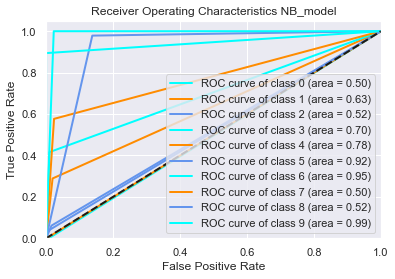

Time taken by NB Gaussian means model:  0.02105099999999993 seconds 

F1 score for iteration:  0.7003236724649644 

ROC_AUC score for iteration:  0.7003236724649644 

TRAIN: [    0     1     2 ... 53859 53860 53861] TEST: [    3    11    12 ... 53852 53853 53856]
n_classes 10
fpr[i]  [0.         0.02098422 1.        ]
tpr[i]  [0. 1. 1.]


<Figure size 432x288 with 0 Axes>

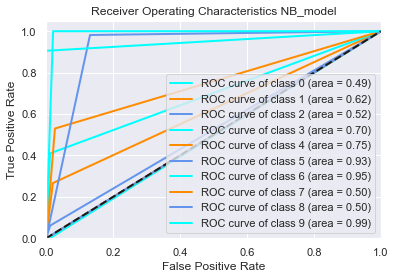

Time taken by NB Gaussian means model:  0.020083999999997104 seconds 

F1 score for iteration:  0.6959757692523934 

ROC_AUC score for iteration:  0.6959757692523934 

TRAIN: [    1     2     3 ... 53859 53860 53861] TEST: [    0     4    18 ... 53842 53850 53858]
n_classes 10
fpr[i]  [0.         0.02302693 1.        ]
tpr[i]  [0. 1. 1.]


<Figure size 432x288 with 0 Axes>

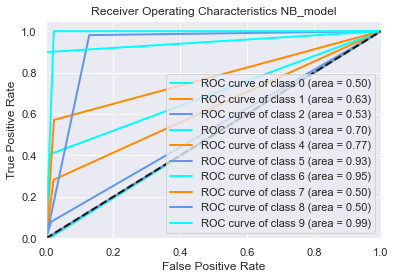

Time taken by NB Gaussian means model:  0.017631999999991876 seconds 

F1 score for iteration:  0.6992080481827707 

ROC_AUC score for iteration:  0.6992080481827707 

TRAIN: [    0     1     3 ... 53856 53858 53860] TEST: [    2     5     6 ... 53857 53859 53861]
n_classes 10
fpr[i]  [0.         0.01940756 1.        ]
tpr[i]  [0. 1. 1.]


<Figure size 432x288 with 0 Axes>

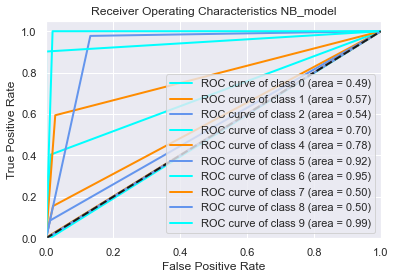

Time taken by NB Gaussian means model:  0.01737500000001546 seconds 

F1 score for iteration:  0.6942967123296003 

ROC_AUC score for iteration:  0.6942967123296003 

TRAIN: [    0     2     3 ... 53859 53860 53861] TEST: [    1     7    14 ... 53818 53832 53843]
n_classes 10
fpr[i]  [0.         0.01922184 1.        ]
tpr[i]  [0. 1. 1.]


<Figure size 432x288 with 0 Axes>

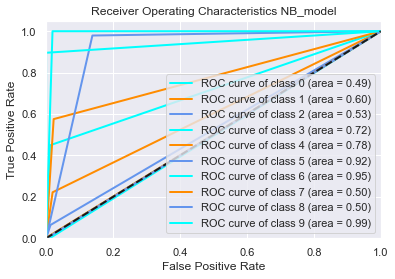

Time taken by NB Gaussian means model:  0.016810999999961496 seconds 

F1 score for iteration:  0.6976052903806595 

ROC_AUC score for iteration:  0.6976052903806595 

F1 score for NB Gaussian model prediction:  [0.8169497818620626, 0.8198273461431356, 0.8191607872261418, 0.8194392870404753, 0.8202747864834756] 

ROC_AUC score for NB Gaussian model prediction:  [0.7003236724649644, 0.6959757692523934, 0.6992080481827707, 0.6942967123296003, 0.6976052903806595] 



<Figure size 432x288 with 0 Axes>

In [54]:
time_NB =[]
skf = StratifiedKFold(n_splits=5,shuffle = True)
nbscore = []
roc_score_nb=[]


# Training Model with Navie Bayes :


for train_index, test_index in skf.split(X, y):
     count = 0
     print("TRAIN:", train_index, "TEST:", test_index)

     X_train, X_test = X[train_index], X[test_index]
     y_train, y_test = y[train_index], y[test_index]
     
     s = time.process_time()
     NB_model = GaussianNB(priors=None, var_smoothing=0.04328761281083057)
     NB_model.fit(X_train,y_train)
     y_pred = NB_model.predict(X_test)

     e = time.process_time() - s
     time_NB.append(e) 
     score = f1_score(y_test,y_pred, average='micro')
     nbscore.append(score)

     lb = preprocessing.LabelBinarizer()
     y_testnb = lb.fit_transform(y_test)
     y_prednb = lb.fit_transform(y_pred)

     score = roc_auc_score(y_testnb,y_prednb)
     roc_score_nb.append(score)
     
     plot_roc(y_pred, y_testnb, y_prednb, 'NB_model',count)
     count+=1

     print("Time taken by NB Gaussian means model: ", e,"seconds \n")
     print("F1 score for iteration: ",score,'\n')
     print("ROC_AUC score for iteration: ",score,'\n')

print("F1 score for NB Gaussian model prediction: ",nbscore,'\n')
print("ROC_AUC score for NB Gaussian model prediction: ",roc_score_nb,'\n')

### Model 4 SVM

TRAIN: [    1     2     3 ... 53859 53860 53861] TEST: [    0     5    13 ... 53839 53841 53856]
n_classes 9
fpr[i]  [0.00000000e+00 1.86202402e-04 1.00000000e+00]
tpr[i]  [0. 0. 1.]


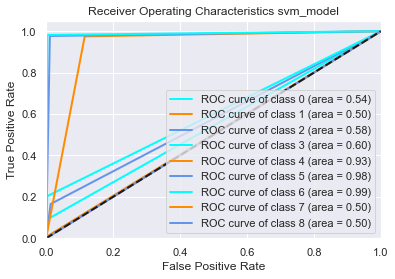

Time taken by svm model:  2.163644999999974 seconds 

F1 score at iterartion :  0.6804988709882877 

ROC_AUC score for iteration:  0.6804988709882877 

TRAIN: [    0     1     2 ... 53859 53860 53861] TEST: [    3     8     9 ... 53843 53851 53853]
n_classes 6
fpr[i]  [0.00000000e+00 7.76518093e-04 1.00000000e+00]
tpr[i]  [0. 0. 1.]


<Figure size 432x288 with 0 Axes>

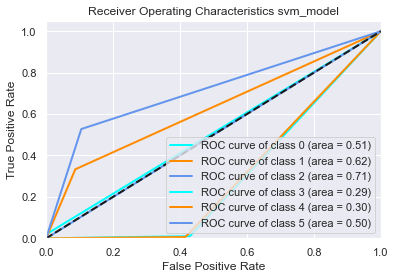

Time taken by svm model:  1.945274999999981 seconds 

F1 score at iterartion :  0.48811864995108034 

ROC_AUC score for iteration:  0.48811864995108034 

TRAIN: [    0     1     2 ... 53857 53859 53861] TEST: [   24    27    29 ... 53850 53858 53860]
n_classes 6
fpr[i]  [0.         0.06539298 1.        ]
tpr[i]  [0.         0.00230734 1.        ]


<Figure size 432x288 with 0 Axes>

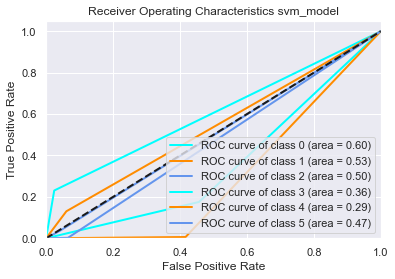

Time taken by svm model:  2.3088470000000143 seconds 

F1 score at iterartion :  0.459697153990207 

ROC_AUC score for iteration:  0.459697153990207 

TRAIN: [    0     3     4 ... 53859 53860 53861] TEST: [    1     2    10 ... 53840 53848 53852]
n_classes 6
fpr[i]  [0.00000000e+00 4.65983225e-04 1.00000000e+00]
tpr[i]  [0. 0. 1.]


<Figure size 432x288 with 0 Axes>

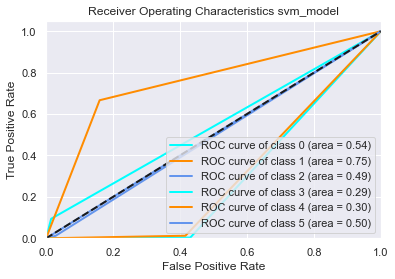

Time taken by svm model:  2.146179000000018 seconds 

F1 score at iterartion :  0.4781449679125813 

ROC_AUC score for iteration:  0.4781449679125813 

TRAIN: [    0     1     2 ... 53856 53858 53860] TEST: [    4     6     7 ... 53857 53859 53861]
n_classes 8
fpr[i]  [0.00000000e+00 9.53107129e-05 1.00000000e+00]
tpr[i]  [0. 0. 1.]


<Figure size 432x288 with 0 Axes>

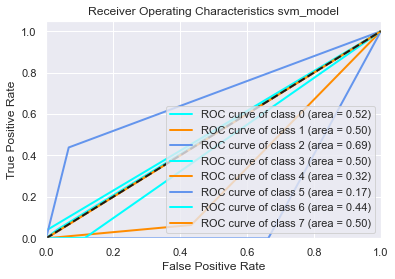

Time taken by svm model:  2.0789290000000165 seconds 

F1 score at iterartion :  0.4543292312298872 

ROC_AUC score for iteration:  0.4543292312298872 

F1 score for svm model prediction:  [0.8541724682075559, 0.8819270398217767, 0.8886000742666171, 0.8851652432231711, 0.8874860750092833] 

ROC_AUC score for svm model prediction:  [0.6804988709882877, 0.48811864995108034, 0.459697153990207, 0.4781449679125813, 0.4543292312298872] 



<Figure size 432x288 with 0 Axes>

In [57]:
# Training Model with SVM Classifier :
svm_score = []
time_svm = []
roc_score_svm=[]
for train_index, test_index in skf.split(X, y):
     count = 0
     print("TRAIN:", train_index, "TEST:", test_index)

     X_train, X_test = X[train_index], X[test_index]
     y_train, y_test = y[train_index], y[test_index]
     
     s = time.process_time()


     svm_model = SGDClassifier( loss = 'hinge' ,alpha= 1e-6,penalty = 'l1')
     svm_model.fit(X_train,y_train)

     y_pred = svm_model.predict(X_test)

     e = time.process_time() - s
     time_svm.append(e) 
     score = f1_score(y_test,y_pred, average='micro')
     svm_score.append(score)

     lb = preprocessing.LabelBinarizer()
     y_testnb = lb.fit_transform(y_test)
     y_prednb = lb.fit_transform(y_pred)

     score = roc_auc_score(y_testnb,y_prednb)
     roc_score_svm.append(score)

     plot_roc(y_pred, y_testnb, y_prednb, 'svm_model',count)
     count+=1

     print("Time taken by svm model: ", e,"seconds \n")
     print("F1 score at iterartion : ",score,'\n')
     print("ROC_AUC score for iteration: ",score,'\n')

print("F1 score for svm model prediction: ",svm_score,'\n')
print("ROC_AUC score for svm model prediction: ",roc_score_svm,'\n')

### Ensemble modeling

In [59]:
from sklearn.ensemble import VotingClassifier
from sklearn.calibration import CalibratedClassifierCV
# Initializing all the 3 classifiers with best found parameters


knn_clf = KNeighborsClassifier( metric = 'manhattan', n_neighbors=11, weights= 'distance')

nb_clf = GaussianNB(priors=None, var_smoothing=0.04328761281083057)

#log_clf = SGDClassifier( alpha= 1e-6,penalty = 'l1')


TRAIN: [    0     1     4 ... 53858 53859 53860] TEST: [    2     3     5 ... 53855 53857 53861]
n_classes 10
fpr[i]  [0.         0.01773445 1.        ]
tpr[i]  [0.         0.66666667 1.        ]


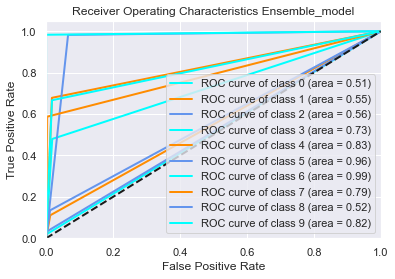

Time taken by voting model:  1.2644149999999854 seconds 

F1 score at iterartion :  0.7262470744251808 

ROC_AUC score for iteration:  0.7262470744251808 

TRAIN: [    1     2     3 ... 53859 53860 53861] TEST: [    0    13    20 ... 53826 53842 53844]
n_classes 10
fpr[i]  [0.         0.02079851 1.        ]
tpr[i]  [0. 1. 1.]


<Figure size 432x288 with 0 Axes>

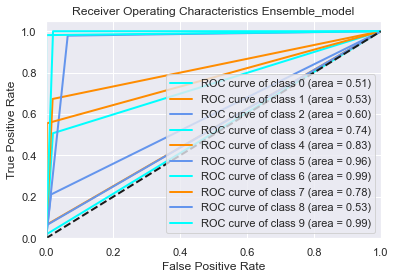

Time taken by voting model:  1.331105999999977 seconds 

F1 score at iterartion :  0.7453883604633647 

ROC_AUC score for iteration:  0.7453883604633647 

TRAIN: [    0     1     2 ... 53859 53860 53861] TEST: [   22    23    33 ... 53854 53856 53858]
n_classes 10
fpr[i]  [0.         0.02042711 1.        ]
tpr[i]  [0. 1. 1.]


<Figure size 432x288 with 0 Axes>

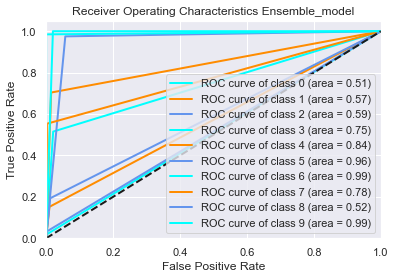

Time taken by voting model:  1.0487059999999815 seconds 

F1 score at iterartion :  0.7493012206768788 

ROC_AUC score for iteration:  0.7493012206768788 

TRAIN: [    0     2     3 ... 53858 53859 53861] TEST: [    1     4     8 ... 53850 53851 53860]
n_classes 10
fpr[i]  [0.         0.01838611 1.        ]
tpr[i]  [0. 1. 1.]


<Figure size 432x288 with 0 Axes>

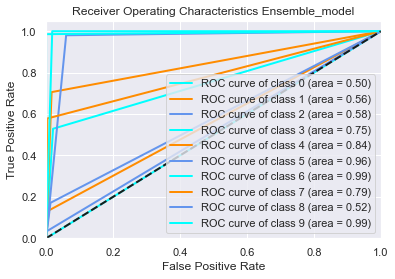

Time taken by voting model:  1.211275999999998 seconds 

F1 score at iterartion :  0.7488195407714648 

ROC_AUC score for iteration:  0.7488195407714648 

TRAIN: [    0     1     2 ... 53858 53860 53861] TEST: [    7    12    18 ... 53848 53852 53859]
n_classes 10
fpr[i]  [0.         0.02005757 1.        ]
tpr[i]  [0. 1. 1.]


<Figure size 432x288 with 0 Axes>

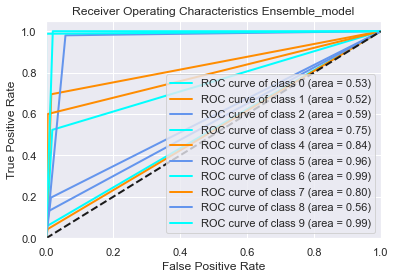

Time taken by voting model:  1.490618999999981 seconds 

F1 score at iterartion :  0.753658741494185 

ROC_AUC score for iteration:  0.753658741494185 

F1 score for voting model prediction:  [0.8805346700083542, 0.8818342151675485, 0.8835870776086149, 0.8871147419235054, 0.8885072409951726] 

ROC_AUC score for voting model prediction:  [0.7262470744251808, 0.7453883604633647, 0.7493012206768788, 0.7488195407714648, 0.753658741494185] 



<Figure size 432x288 with 0 Axes>

In [62]:

v_score = []
time_v = []
roc_score_v=[]
for train_index, test_index in skf.split(X, y):
     count = 0
     print("TRAIN:", train_index, "TEST:", test_index)

     X_train, X_test = X[train_index], X[test_index]
     y_train, y_test = y[train_index], y[test_index]
     
     s = time.process_time()


     v_model = VotingClassifier(estimators=[('knn', knn_clf),('nb', nb_clf)], voting='soft', n_jobs=-1)
     v_model.fit(X_train,y_train)

     y_pred = v_model.predict(X_test)

     e = time.process_time() - s
     time_v.append(e) 
     score = f1_score(y_test,y_pred, average='micro')
     v_score.append(score)

     lb = preprocessing.LabelBinarizer()
     y_testnb = lb.fit_transform(y_test)
     y_prednb = lb.fit_transform(y_pred)

     score = roc_auc_score(y_testnb,y_prednb)
     roc_score_v.append(score)

     plot_roc(y_pred, y_testnb, y_prednb, 'Ensemble_model',count)
     count+=1

     print("Time taken by voting model: ", e,"seconds \n")
     print("F1 score at iterartion : ",score,'\n')
     print("ROC_AUC score for iteration: ",score,'\n')

print("F1 score for voting model prediction: ",v_score,'\n')
print("ROC_AUC score for voting model prediction: ",roc_score_v,'\n')

In [66]:
f1 = []
f1.append(nn_score)
f1.append(lr_score)

f1.append(nbscore)

f1.append(svm_score)
f1.append(v_score)

In [67]:
time = []
time.append(nn_time)
time.append(lr_time)
time.append(time_svm)
time.append(time_NB)

time.append(time_v)

In [68]:
roc_aoc = []
roc_aoc.append(roc_score_knn)
roc_aoc.append(roc_score_log)
roc_aoc.append(roc_score_svm)
roc_aoc.append(roc_score_nb)

roc_aoc.append(roc_score_v)

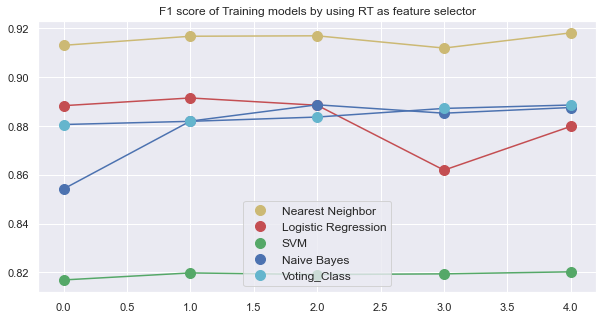

In [72]:
plot_F1score_metrics('F1 score of Training models by using RT as feature selector',f1,"Nearest Neighbor","Logistic Regression","SVM","Naive Bayes","Voting_Class")


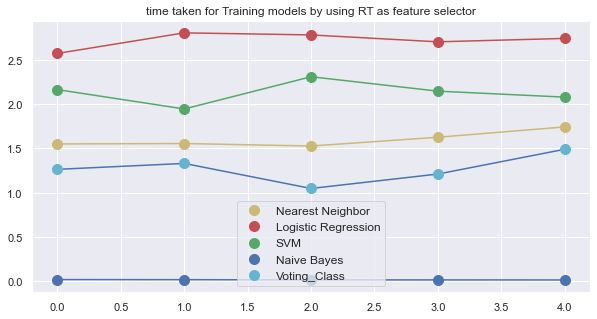

In [73]:
plot_F1score_metrics('time taken for Training models by using RT as feature selector',time,"Nearest Neighbor","Logistic Regression","SVM","Naive Bayes","Voting_Class")


In [ ]:
plot_metrics("Method 1 Feature Selection ROC Scores",roc_aoc,"KNN","Naive Bayes","Logistic","SVM","ENSEMBLE")

In [74]:
# plotting time taken by each model
nn_time_avg = np.mean(nn_time)
lr_time_avg = np.mean(lr_time)
svm_time_avg = np.mean(time_svm)
nb_time_avg = np.mean(time_NB)

v_time_avg = np.mean(time_v)
print(v_time_avg)

1.2692243999999846


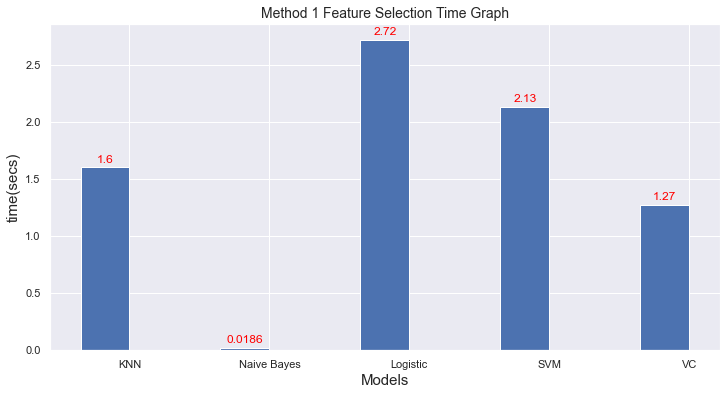

In [76]:
%matplotlib inline
import matplotlib.pyplot as plt


from matplotlib import pyplot as plt
import numpy as np

Models = ['KNN','Naive Bayes','Logistic','SVM', 'VC']
time = [nn_time_avg, nb_time_avg, lr_time_avg, svm_time_avg, v_time_avg]



from matplotlib import pyplot as plt
import numpy as np


x = np.arange(len(Models)) # the label locations
width = 0.35 # the width of the bars

fig, ax = plt.subplots(figsize=(12,6))
ax.set_xlabel('Models',fontsize=15)
ax.set_ylabel('time(secs)',fontsize=15)
ax.set_title("Method 1 Feature Selection Time Graph", fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(Models)

pps = ax.bar(x - width/2, time, width,align='center', label='time')
for p in pps:
   height = p.get_height()
   ax.annotate('{:.3}'.format(height),
      xy=(p.get_x() + p.get_width() / 2, height),
      xytext=(0, 3), # 3 points vertical offset
      textcoords="offset points", 
      ha='center', va='bottom', fontsize=12, color = 'red')

plt.show()

In [77]:
# plotting f1 score
nn_score_avg = np.mean(nn_score)
lr_score_avg = np.mean(lr_score)
svm_score_avg = np.mean(svm_score)
nbscore_avg = np.mean(nbscore)

v_score_avg = np.mean(v_score)

print(f1_score)

# Average ROC-AOC


avg_roc_score_knn = np.mean(roc_score_svm)
avg_roc_score_log= np.mean(roc_score_log)
avg_roc_score_nb = np.mean(roc_score_nb)

avg_roc_score_svm= np.mean(roc_score_svm)
avg_roc_score_v = np.mean(roc_score_v)


<function f1_score at 0x7f7ff0bb41f0>


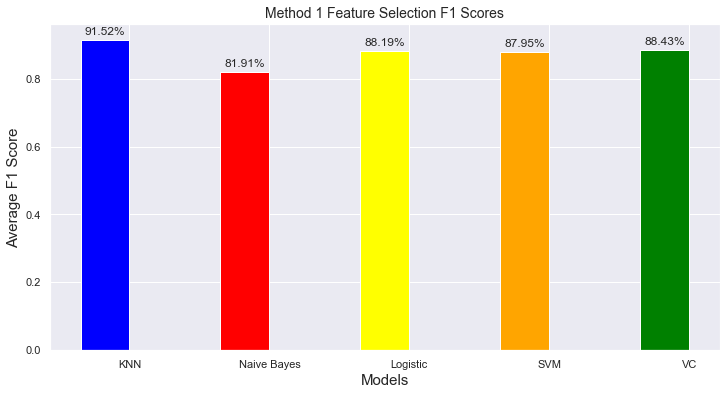

In [78]:



from matplotlib import pyplot as plt
import numpy as np

Models = ['KNN','Naive Bayes','Logistic','SVM', 'VC']
F1Score = [nn_score_avg,nbscore_avg,lr_score_avg,svm_score_avg,v_score_avg]



from matplotlib import pyplot as plt
import numpy as np


x = np.arange(len(Models)) # the label locations
width = 0.35 # the width of the bars

fig, ax = plt.subplots(figsize=(12,6))
ax.set_xlabel('Models',fontsize=15)
ax.set_ylabel('Average F1 Score',fontsize=15)
ax.set_title('Method 1 Feature Selection F1 Scores', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(Models)

pps = ax.bar(x - width/2, F1Score, width,align='center', label='F1Score',color = ['blue', 'red', 'yellow', 'orange', 'green'])
for p in pps:
   height = p.get_height()
   ax.annotate('{:.2%}'.format(height),
      xy=(p.get_x() + p.get_width() / 2, height),
      xytext=(0, 3), # 3 points vertical offset
      textcoords="offset points", 
      ha='center', va='bottom', fontsize=12)

plt.show()








### Show as a Dataframe

In [79]:
# An empty dictionary to store the result of all the models
result_dict = {"name":[], "auc":[], "f1":[]}

# Saving result of KNN
result_dict['name'].append("KNN")
result_dict['auc'].append(avg_roc_score_knn)
result_dict['f1'].append(nn_score_avg)


# Saving result of log
result_dict['name'].append("LOG")
result_dict['auc'].append(avg_roc_score_log)
result_dict['f1'].append(lr_score_avg )


# Saving result of NB
result_dict['name'].append("NB")
result_dict['auc'].append(avg_roc_score_nb )
result_dict['f1'].append(nbscore_avg)


# Saving result of SVM
result_dict['name'].append("SVM")
result_dict['auc'].append(avg_roc_score_svm)
result_dict['f1'].append(svm_score_avg )




# Saving result of Ensemble
result_dict['name'].append("ENSEMBLE")
result_dict['auc'].append(avg_roc_score_v)
result_dict['f1'].append(v_score_avg)




In [80]:
pd.DataFrame(result_dict)

,name,auc,f1
0,KNN,0.512158,0.915246
1,LOG,0.553539,0.881939
2,NB,0.697482,0.819130
3,SVM,0.512158,0.879470
4,ENSEMBLE,0.744683,0.884316
